# 4-Oscar Prediction with AutoML
After out dataframe has been assemlbed (see scraping and table_assembling) notebooks we have the data we need to make predictions on the Best Picture winner. [AutoML](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html) represents a quick, but powerful route though the Machine Learning process. H2O's AutoML runs many models through the dataset and using cross-validation, picks the best one. For my purposes I use it to confirm/compare to the Preferential Balloting Random Forest model I created.
If you are gunning to win your office's Oscar pool, scroll down to see the results.

In [1]:
import pandas as pd
import numpy as np
import h2o

# Machine Learning - Using h2o Auto ML

In [9]:
full_table = pd.read_csv('../data/processed_results/everything.csv')
full_table=full_table.drop(['Unnamed: 0'], axis=1)
full_table

,year,film,wiki,rating,numVotes,worldwide_box_office,action,adventure,animation,biography,...,winner_sag,Acting,Production Design,Directing,VFX,Writing,Cinematography,Sound,Film Editing,Music
0,1927,Wings,/wiki/Wings_(1927_film),7.3,13576.0,746,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1927,7th Heaven,/wiki/7th_Heaven_(1927_film),5.2,26223.0,79808,0,0,0,0,...,0,1,1,1,0,1,0,0,0,0
2,1927,The Racket,/wiki/The_Racket_(1928_film),6.7,3149.0,21733230,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1928,The Broadway Melody,/wiki/The_Broadway_Melody,5.6,7605.0,223723,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,1928,Alibi,/wiki/Alibi_(1929_film),7.4,391.0,42915,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2022,The Fabelmans,/wiki/The_Fabelmans,7.6,85709.0,45164110,0,0,0,0,...,0,1,1,1,0,1,0,0,0,1
469,2022,Tár,/wiki/T%C3%A1r,7.5,69684.0,27541681,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
470,2022,Top Gun: Maverick,/wiki/Top_Gun:_Maverick,8.3,577408.0,1493491858,0,0,0,0,...,0,0,0,0,1,1,0,1,1,1
471,2022,Triangle of Sadness,/wiki/Triangle_of_Sadness,7.3,128812.0,25615870,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 20 mins
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_aczaplak_evj1hv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.533 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


First Year of Existance. This data will be used below
- golden_globes 1943
- pga 1989
- bafta 1960
- dga 1948
- sag 1995
- cannes 1970

In [10]:
# I pick a min_year where the awards shows will be relevant
min_year = 1995

# H2O's Auto ML

In [11]:
# Auto ML uses Cross Validation, so we do not specifiy a validation set
train = full_table.loc[((full_table['year'] < 2022) & (full_table['year'] >= min_year))]

print('training set contains:', train.shape[0], 'movies')

training set contains: 176 movies


In [12]:
#train = train.drop(['index', '[]'], axis=1)
train.columns

Index(['year', 'film', 'wiki', 'rating', 'numVotes', 'worldwide_box_office',
       'action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'game-show',
       'history', 'horror', 'music', 'musical', 'mystery', 'news',
       'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show',
       'thriller', 'war', 'western', 'nominations', 'Oscar_win',
       'nom_gg_drama', 'winner_gg_drama', 'nom_gg_comedy', 'winner_gg_comedy',
       'nom_pga', 'winner_pga', 'nom_bafta', 'winner_bafta', 'nom_dga',
       'winner_dga', 'nom_sag', 'winner_sag', 'Acting', 'Production Design',
       'Directing', 'VFX', 'Writing', 'Cinematography', 'Sound',
       'Film Editing', 'Music'],
      dtype='object')

In [7]:
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [13]:
from h2o.automl import H2OAutoML, get_leaderboard

# Import a sample binary outcome train/test set into H2O
train1 = h2o.H2OFrame(train)

# Identify predictors and response
predictors = [ 'rating', 'numVotes', 'worldwide_box_office',
       'action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'game-show',
       'history', 'horror', 'music', 'musical', 'mystery', 'news',
       'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show',
       'thriller', 'war', 'western', 'nominations',
       'nom_gg_drama', 'winner_gg_drama', 'nom_gg_comedy', 'winner_gg_comedy',
       'nom_pga', 'winner_pga', 'nom_bafta', 'winner_bafta', 'nom_dga',
       'winner_dga', 'nom_sag', 'winner_sag', 'Acting', 'Production Design',
       'Directing', 'VFX', 'Writing', 'Cinematography', 'Sound',
       'Film Editing', 'Music']

x = predictors
y = 'Oscar_win'

# For binary classification, response should be a factor
train1[y] = train1[y].asfactor()

# Run AutoML for 100 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=100, seed=1
                , keep_cross_validation_predictions= True,
                balance_classes=True,
               sort_metric="aucpr")

aml.train(x=x, y=y, training_frame=train1)

# AutoML Leaderboard
lb = aml.leaderboard

# Optionally edd extra model information to the leaderboard
lb = get_leaderboard(aml, extra_columns='ALL')

# Print all rows (instead of default 10 rows)
lb.head(rows=lb.nrows)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:42:20.644: AutoML: XGBoost is not available; skipping it.
14:42:20.657: _train param, Dropping bad and constant columns: [film-noir]
14:42:21.127: _train param, Dropping bad and constant columns: [film-noir]
14:42:21.127: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 176.0.
14:42:21.128: _train param, Dropping bad and constant columns: [film-noir]
14:42:21.883: _train param, Dropping bad and constant columns: [film-noir]
14:42:22.491: _train param, Dropping bad and constant columns: [film-noir]
14:42:23.172: _train param, Dropping bad and constant columns: [film-noir]
14:42:23.805: _train param, Dropping bad and constant columns: [film-noir]
14:42:24.261: _train param, Dropping bad and constant columns: [film-noir]
14:42:24.842: _train param, Dropping bad and constant columns: [film-no

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
DeepLearning_grid_2_AutoML_3_20230608_144220_model_13,0.494783,0.814872,0.381371,0.22641,0.331731,0.110046,3851,0.086353,DeepLearning
StackedEnsemble_BestOfFamily_1_AutoML_3_20230608_144220,0.457002,0.802308,0.342625,0.274103,0.323478,0.104638,1944,0.114743,StackedEnsemble
DeepLearning_grid_3_AutoML_3_20230608_144220_model_2,0.431139,0.771282,0.568379,0.237179,0.358414,0.12846,2715,0.060469,DeepLearning
DeepLearning_grid_1_AutoML_3_20230608_144220_model_7,0.424932,0.684359,0.738602,0.346923,0.373988,0.139867,5129,0.08029,DeepLearning
DeepLearning_grid_3_AutoML_3_20230608_144220_model_14,0.415152,0.771282,0.529617,0.327692,0.375706,0.141155,5299,0.062132,DeepLearning
DeepLearning_grid_2_AutoML_3_20230608_144220_model_18,0.412036,0.768462,0.520966,0.287436,0.403292,0.162645,2598,0.044075,DeepLearning
DeepLearning_grid_2_AutoML_3_20230608_144220_model_8,0.409247,0.711282,0.621093,0.347692,0.375367,0.1409,5391,0.053757,DeepLearning
DeepLearning_grid_3_AutoML_3_20230608_144220_model_11,0.408695,0.743333,0.510695,0.284872,0.343912,0.118275,2744,0.053355,DeepLearning
GLM_1_AutoML_3_20230608_144220,0.404745,0.797692,0.359395,0.3,0.334009,0.111562,41,0.025502,GLM
DeepLearning_grid_3_AutoML_3_20230608_144220_model_1,0.403011,0.755641,0.817069,0.325128,0.408279,0.166692,5525,0.074885,DeepLearning


In [14]:
top_model_new= aml.leader
top_model_new

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_2_AutoML_3_20230608_144220_model_13


Status of Neuron Layers: predicting Oscar_win, 2-class classification, bernoulli distribution, CrossEntropy loss, 5 252 weights/biases, 72,2 KB, 224 250 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight            weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  --------------------  ----------  ---------------------  -------------------  --------------------  --------------------
    1        51       Input             5.0
    2        50       RectifierDropout  40.0       0.0   0.0   0.010780249038697209  0.029258765280246735  0.0         0.026089730081089953   0.17541611194610596  0.38150274871663625   0.060948774218559265
    3        50       RectifierDropout  40.0       0.0   0.0   0.00662804153302568   0.018783636391162872  0.0         -0.023351517959643388  0.16132253408432007  0.76410611712203      0.1725260615348816
    4        2        Softmax                      0.0   0.0   0.00559106535394676   0.007647812366485596  0.0         0.0397905883891508     0.8129417896270752   0.005130655186144767  0.003059481270611286

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.00017175285585479955
RMSE: 0.013105451379284865
LogLoss: 0.0015422949968064003
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9882505294550806
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      150  0    0        (0.0/150.0)
1      0    149  0        (0.0/149.0)
Total  150  149  0        (0.0/299.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.988251     1         25
max f2                       0.988251     1         25
max f0point5                 0.988251     1         25
max accuracy                 0.988251     1         25
max precision                0.999999     1         0
max recall                   0.988251     1         25
max specificity              0.999999     1         0
max absolute_mcc             0.988251     1         25
max min_per_class_accuracy   0.988251     1         25
max mean_per_class_accuracy  0.988251     1         25
max tns                      0.999999     150       0
max fns                      0.999999     143       0
max fps                      9.91463e-20  150       175
max tps                      0.988251     149       25
max tnr                      0.999999     1         0
max fnr                      0.999999     0.959732  0
max fpr                      9.91463e-20  1         175
max tpr                      0.988251     1         25

Gains/Lift Table: Avg response rate: 49,83 %, avg score: 49,88 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0200669                   0.999999           2.00671  2.00671            1                0.999999     1                           0.999999            0.0402685       0.0402685                  100.671  100.671            0.0402685
2        0.0200669                   0.999996           0        2.00671            0                0            1                           0.999999            0       

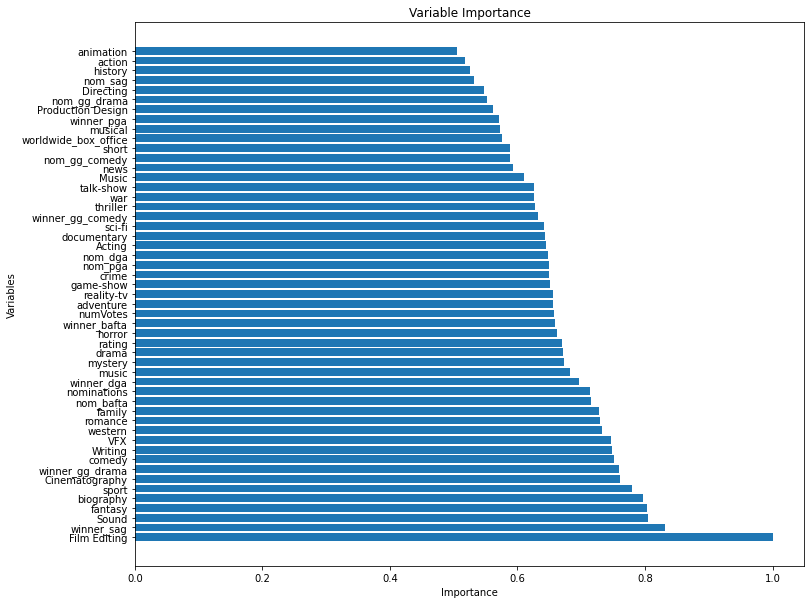

In [15]:
import matplotlib.pyplot as plt
# Get the variable importance table
var_importance = aml.leader.varimp()

# Extract variable names and importances
variables = [item[0] for item in var_importance]
importances = [item[1] for item in var_importance]


# Set the figure size
plt.figure(figsize=(12, 10))

# Plot the variable importance
plt.barh(variables, importances)
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Variable Importance")
plt.show()

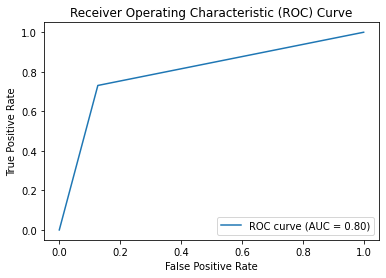

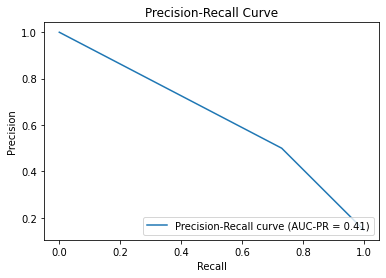

In [16]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# Get the cross-validated predictions and true labels
preds = aml.leader.cross_validation_holdout_predictions().as_data_frame()["predict"].values
true_labels = train[y].values

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

# Calculate the precision-recall curve and AUC-PR
precision, recall, _ = precision_recall_curve(true_labels, preds)
pr_auc = average_precision_score(true_labels, preds)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the precision-recall curvea
plt.plot(recall, precision, label='Precision-Recall curve (AUC-PR = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## Predict the winner

In [18]:
# Predict on 2019's films
test = full_table.loc[(full_table['year'] == 2021)]

# Import a binary outcome train/test set into H2O
test = h2o.H2OFrame(test)

# For binary classification, response should be a factor
test[y] = test[y].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
preds = top_model_new.predict(test)

preds

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.000460625,0.999539
0,1,3.41566e-08
0,1,2.0236e-08
0,0.999992,8.00619e-06
0,0.999999,6.91682e-07
0,1,1.81344e-07
0,1,9.58084e-15
0,1,3.15706e-15
0,1,1.77889e-07
0,0.997442,0.00255783


In [20]:
test['pred'] = preds['predict']
test['probA'] = preds['p1']
test_pd = test.as_data_frame(use_pandas=True)

In [21]:
final_rankings = test_pd[['film','probA']].sort_values('probA', ascending = False)
final_rankings['%_confidence'] = final_rankings['probA']/final_rankings['probA'].sum() * 100
final_rankings

,film,probA,%_confidence
0,CODA,9.995394e-01,9.974385e+01
9,West Side Story,2.557825e-03,2.552449e-01
3,Drive My Car,8.006192e-06,7.989364e-04
4,Dune,6.916823e-07,6.902285e-05
5,King Richard,1.813438e-07,1.809626e-05
8,The Power of the Dog,1.778893e-07,1.775154e-05
1,Belfast,3.415659e-08,3.408480e-06
2,Don't Look Up,2.023603e-08,2.019350e-06
6,Licorice Pizza,9.580839e-15,9.560702e-13
7,Nightmare Alley,3.157064e-15,3.150428e-13


# And the Oscar goes to...

In [15]:
bp_winner = np.array(final_rankings.reset_index())[0][1].split('(')[0].strip()
print(f'And the Oscar goes to...\n🎉🏆{bp_winner}🏆🎉')

And the Oscar goes to...
🎉🏆CODA🏆🎉
